In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex
from tqdm import tnrange

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [3]:
torch.manual_seed(33)

In [4]:
from simple_relational_reasoning.datagen import *
from simple_relational_reasoning.datagen import object_gen
from simple_relational_reasoning.models import MLPModel, RelationNetModel

import run
from defaults import FIELD_CONFIGURATIONS

In [5]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\nWrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [6]:
from collections import namedtuple
VisualizationDefinition = namedtuple('VisualizationDefinition', ('name', 'patch_class', 'offset', 'patch_args'))
VISUALIZATION_DEFINITIONS = (
    VisualizationDefinition('square', mpatches.Rectangle, np.array([0, 0]), (10, 10)),
    VisualizationDefinition('circle', mpatches.Ellipse, np.array([5, 5]), (10, 10)),
    VisualizationDefinition('triangle', mpatches.RegularPolygon, np.array([5, 5]), (3, 6)),
    VisualizationDefinition('pentagon', mpatches.RegularPolygon, np.array([5, 5]), (5, 5.5)),
)


DEFAULT_PATCH_KWARGS = dict(ec='none')
DEFAULT_SCALE = 10


def object_to_patch(object_tensor, field_slices, 
                    x_field='x', y_field='y', 
                    x_length_field='x_len', y_length_field='y_len',
                    x_end_field='x_end', y_end_field='y_end',
                    color_field='color', shape_field='shape',
                    scale=DEFAULT_SCALE, additional_patch_kwargs=None, 
                    visualization_definitions=VISUALIZATION_DEFINITIONS):
    
    patch_kwargs = DEFAULT_PATCH_KWARGS.copy()
    if additional_patch_kwargs is not None: 
        patch_kwargs.update(additional_patch_kwargs)
    
    x = int(object_tensor[field_slices[x_field]])
    y = int(object_tensor[field_slices[y_field]])
    position = np.array([x, y]) * scale
    
    shape_index = 0
    if shape_field in field_slices:
        shape_index = int(torch.nonzero(object_tensor[field_slices[shape_field]]).squeeze())
        
    color_index = 0
    if color_field in field_slices:
        color_index = int(torch.nonzero(object_tensor[field_slices[color_field]]).squeeze())
        
    
    vis_def = visualization_definitions[shape_index]
    offset = vis_def.offset
    patch_args = vis_def.patch_args
    
    x_len = 1
    if x_length_field in field_slices:
        x_len = object_tensor[field_slices[x_length_field]]
    elif x_end_field in field_slices:
        x_len = max((object_tensor[field_slices[x_end_field]] - x).item(), 1)
        
    y_len = 1
    if y_length_field in field_slices:
        y_len = object_tensor[field_slices[y_length_field]]

    angle = 0
    if y_end_field in field_slices:
        delta_y = (object_tensor[field_slices[y_end_field]] - y).item()
        delta_x = (object_tensor[field_slices[x_end_field]] - x).item()
        
        if delta_x == 0:
            if delta_y == 0:
                angle = 0
            else:
                angle = 90
        else:
            angle = np.rad2deg(np.arctan(delta_y / delta_x))
        
        if np.isnan(angle):
            angle = 0

    patch_kwargs['angle'] = angle

    # TODO: think about how to cuse x_end and y_end here when supplied
        
    offset = np.multiply(offset, np.array([x_len, y_len]))
    patch_args = [patch_args[0] * x_len, patch_args[1] * y_len] + list(patch_args[2:])
    
    patch = vis_def.patch_class(position + offset, *patch_args, **patch_kwargs)
    
    return patch, color_index


def create_patches_and_colors(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
    
    patches, colors = zip(*[object_to_patch(objects[i], object_generator.field_slices, 
                                            x_field=x_field, y_field=y_field, 
                                            color_field=color_field, shape_field=shape_field, 
                                            scale=scale, additional_patch_kwargs=additional_patch_kwargs,
                                            visualization_definitions=visualization_definitions)
                            for i in range(objects.shape[0])])
    
    return patches, colors


def visualize_objects(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
   
    call_show = False
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        call_show = True

    x_gen = object_generator.field_generators[x_field]
    plt.xlim(x_gen.min_coord * scale, x_gen.max_coord * scale)
    y_gen = object_generator.field_generators[y_field]
    plt.ylim(y_gen.min_coord * scale, y_gen.max_coord * scale)
    ax.set_facecolor(bg_color)
    
    patches, colors = create_patches_and_colors(
        objects=objects, object_generator=object_generator, ax=ax, x_field=x_field,
        y_field=y_field, color_field=color_field, shape_field=shape_field,
        scale=scale, additional_patch_kwargs=additional_patch_kwargs,
        visualization_definitions=visualization_definitions
    )
    
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    
    if bg_color == 'black':
        collection.set_edgecolor('white')
    else:
        collection.set_edgecolor('black')
    collection.set_clim(*clim)
    ax.add_collection(collection)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if call_show:
        plt.show()
    

In [7]:
NAMES = {
    # AboveBelowReferenceInductiveBias: 'above vs. below',
    # BetweenReferenceInductiveBias: 'above vs. below vs. between',
    ObjectGeneratorWithoutSize: 'objects without size',
    ObjectGeneratorWithSize: 'objects with size',
    StartEndObjectGenerator: 'objects with start and end',
}


EXAMPLES_PER_CLASS = 3


def plot_single_dataset(dataset, indices, faux_generators):
    label_arr = np.array(dataset.labels)
    unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
    
    n_labels = len(unique_labels)
    n_panels = n_labels * EXAMPLES_PER_CLASS
    plt.figure(figsize=(4.5 * n_panels, 4))
    plt.suptitle(title.title())

    for l_i, label in enumerate(unique_labels):
        if label not in indices:
            indices[label] = np.random.permutation(np.argwhere(label_arr == label))[:EXAMPLES_PER_CLASS].squeeze()

        for ex_i, ex in enumerate(indices[label]):
            ax = plt.subplot(1, n_panels, 1 + (l_i * EXAMPLES_PER_CLASS) + ex_i)
            ax.set_title(f'C = {label} (#{ex})')
            visualize_objects(dataset[ex][0], faux_generators[generator_class], ax=ax)
            
    plt.show()



-----

-----

# One or two reference objects paradigm

In [8]:
MAX_COORD = 18
MAX_LENGTH = 10
N_TYPES = 2

ONE_OR_TWO_QUINN_FAUX_GENERATORS = defaultdict(dict)

for between_relation in (False, True):
    for two_reference_objects in (False, True):
        if between_relation and not two_reference_objects:
            continue

        baseline_field_config = [
            object_gen.FieldConfig('x', 'int_position', dict(max_coord=MAX_COORD)),
            object_gen.FieldConfig('y', 'int_position', dict(max_coord=MAX_COORD + int(two_reference_objects))),
            object_gen.FieldConfig('color', 'one_hot', dict(n_types=N_TYPES)),
        ]

        for obj_generetor_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize, StartEndObjectGenerator):
            field_config_copy = baseline_field_config[:]
            if obj_generetor_class == ObjectGeneratorWithSize:                
                field_config_copy.insert(2, object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=MAX_LENGTH)))
            elif obj_generetor_class == StartEndObjectGenerator:
                field_config_copy.insert(2, object_gen.FieldConfig('x_end', 'int_position', dict(max_coord=MAX_COORD)))
                field_config_copy.insert(3, object_gen.FieldConfig('y_end', 'int_position', dict(max_coord=MAX_COORD + int(two_reference_objects))))
            
            faux_generator = ObjectGenerator(1, field_config_copy, BetweenRelation)
            ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)][obj_generetor_class] = faux_generator


ONE_OR_TWO_QUINN_FAUX_GENERATORS

defaultdict(dict,
            {(False,
              False): {simple_relational_reasoning.datagen.quinn_objects.ObjectGeneratorWithoutSize: <simple_relational_reasoning.datagen.object_gen.ObjectGenerator at 0x7fad7abe2b80>, simple_relational_reasoning.datagen.quinn_objects.ObjectGeneratorWithSize: <simple_relational_reasoning.datagen.object_gen.ObjectGenerator at 0x7fad38768bb0>, simple_relational_reasoning.datagen.quinn_objects.StartEndObjectGenerator: <simple_relational_reasoning.datagen.object_gen.ObjectGenerator at 0x7fad7abe2af0>},
             (False,
              True): {simple_relational_reasoning.datagen.quinn_objects.ObjectGeneratorWithoutSize: <simple_relational_reasoning.datagen.object_gen.ObjectGenerator at 0x7fad7abe2d00>, simple_relational_reasoning.datagen.quinn_objects.ObjectGeneratorWithSize: <simple_relational_reasoning.datagen.object_gen.ObjectGenerator at 0x7fad7abe2a90>, simple_relational_reasoning.datagen.quinn_objects.StartEndObjectGenerator: <simple_relational

## Above/below | one reference object | objects without size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1825 | 1: 1803

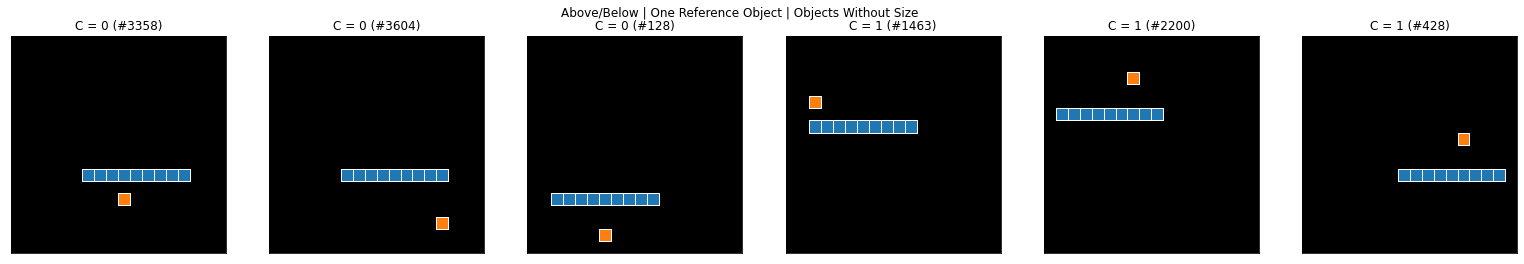

### train_reference_test_target

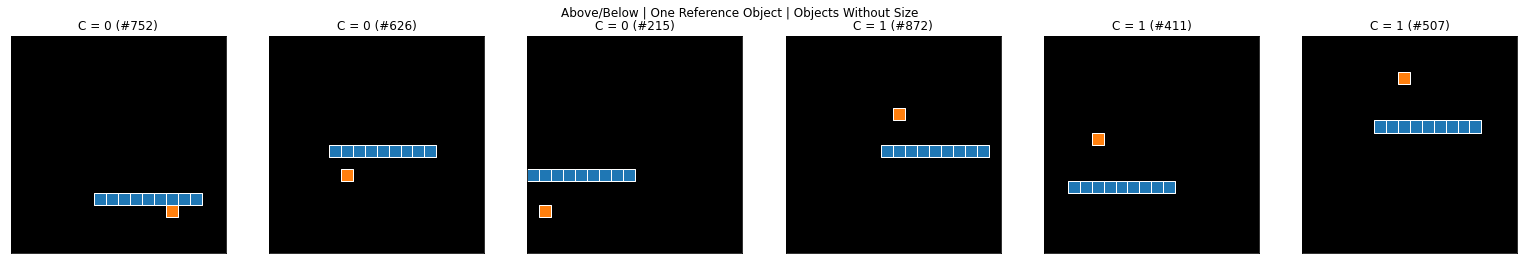

### test_reference_train_target

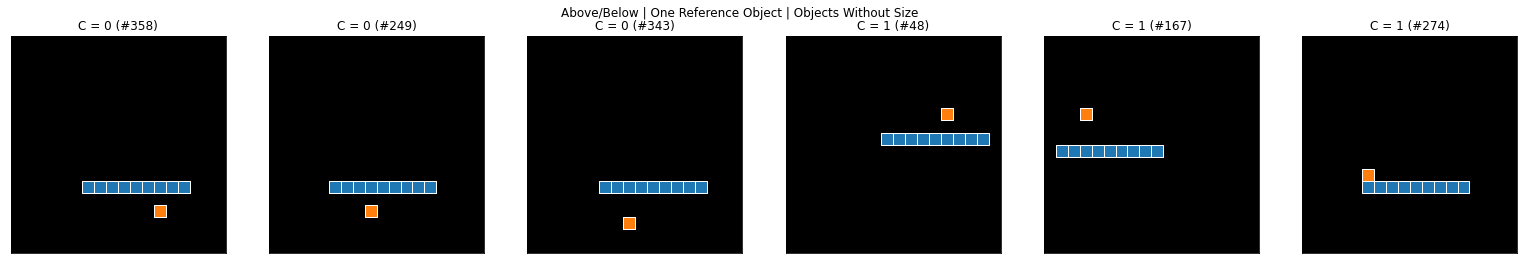

### test_reference_test_target

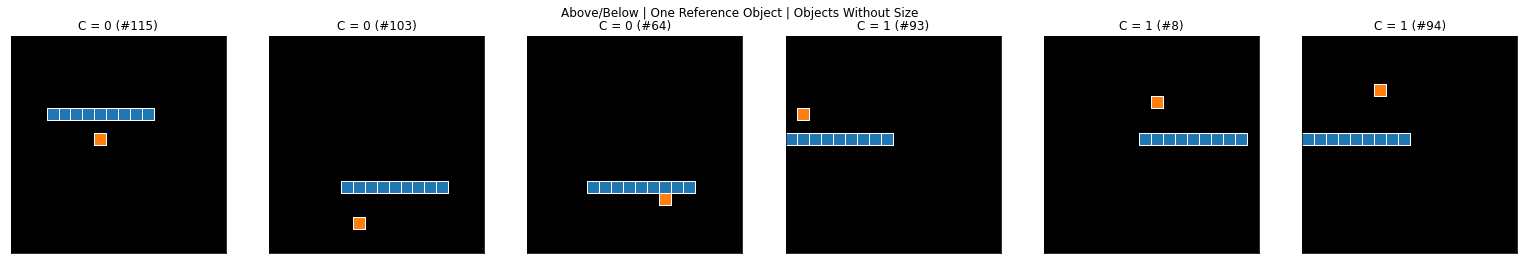

-----

-----

## Above/below | one reference object | objects with size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1825 | 1: 1803

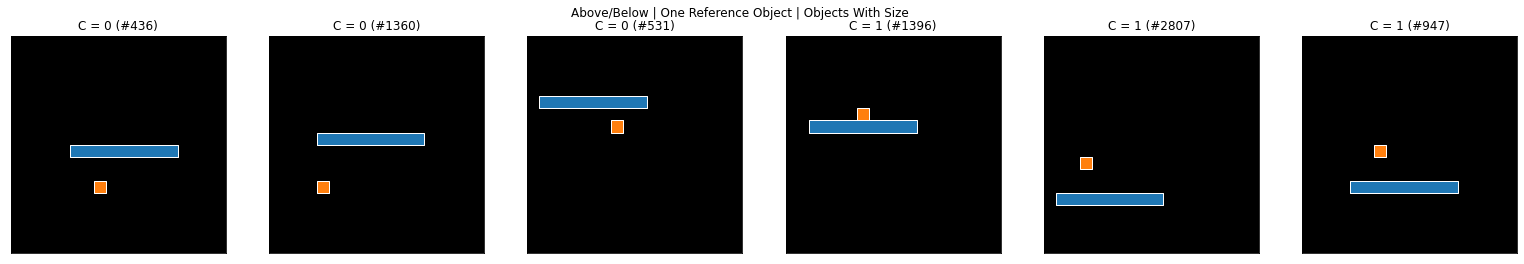

### train_reference_test_target

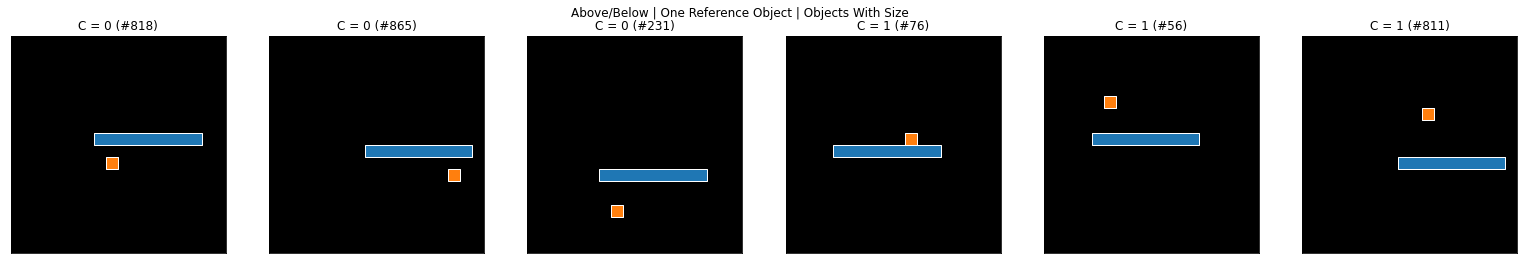

### test_reference_train_target

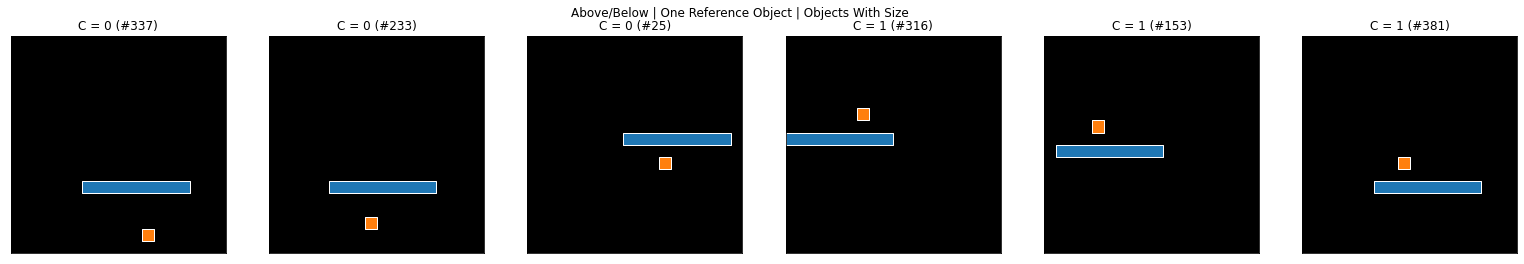

### test_reference_test_target

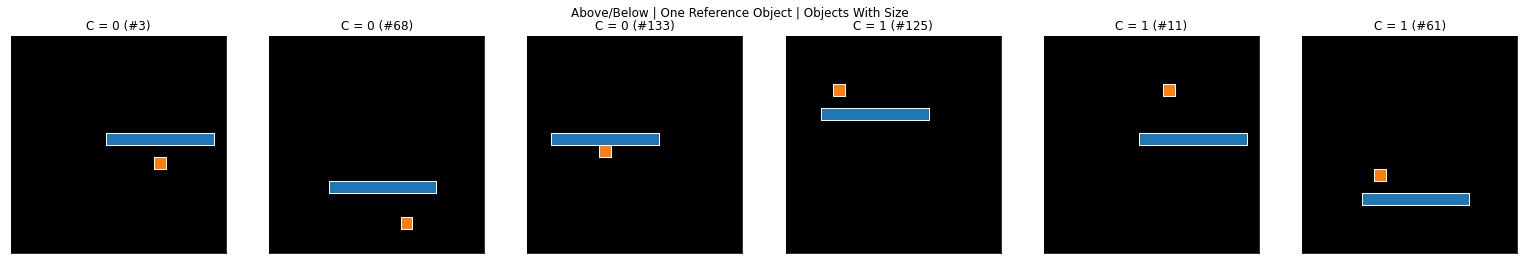

-----

-----

## Above/below | two reference objects | objects without size

Of the reference object locations, train: 72, test: 9 

Training set size: 1814 | Validation set size: 202 | Test set size: 900

Class balance in the training set: 0: 909 | 1: 905

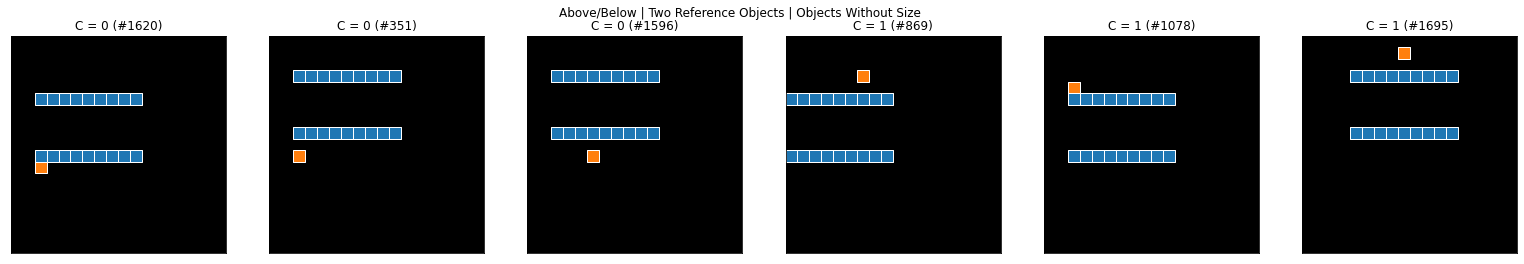

### train_reference_test_target

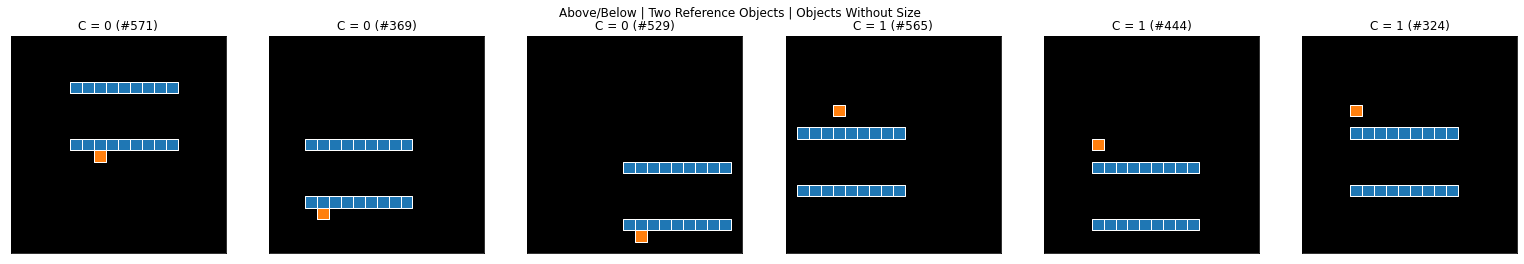

### test_reference_train_target

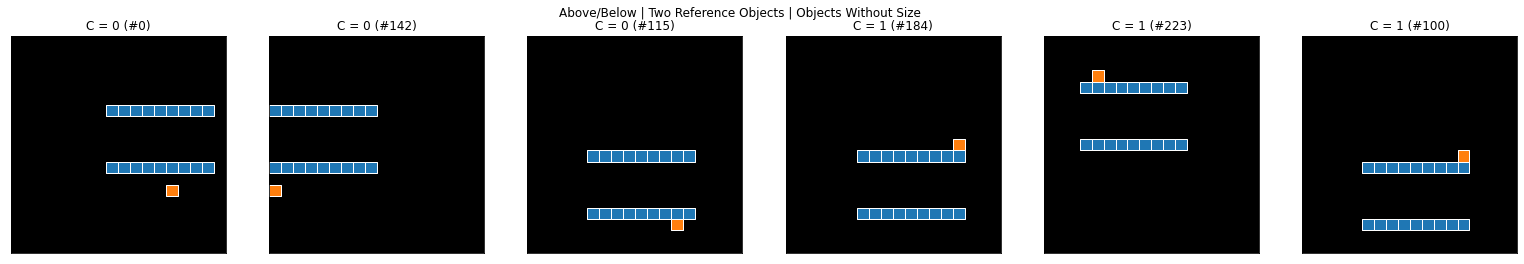

### test_reference_test_target

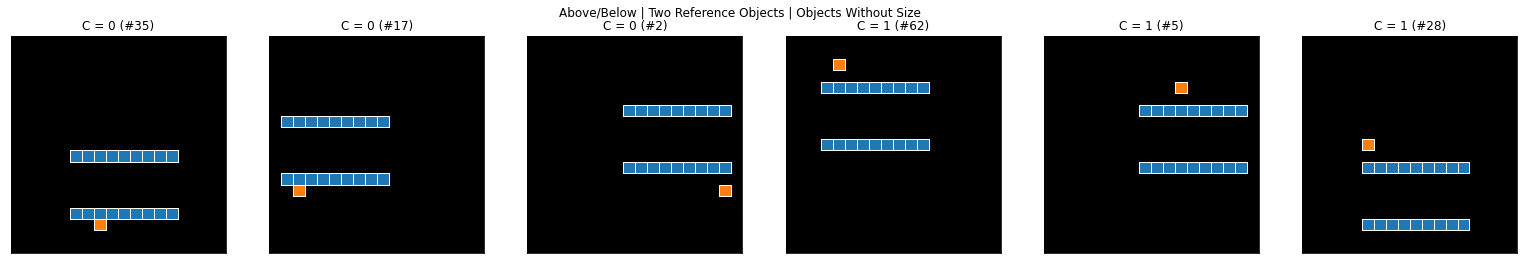

-----

-----

## Above/below | two reference objects | objects with size

Of the reference object locations, train: 72, test: 9 

Training set size: 1814 | Validation set size: 202 | Test set size: 900

Class balance in the training set: 0: 909 | 1: 905

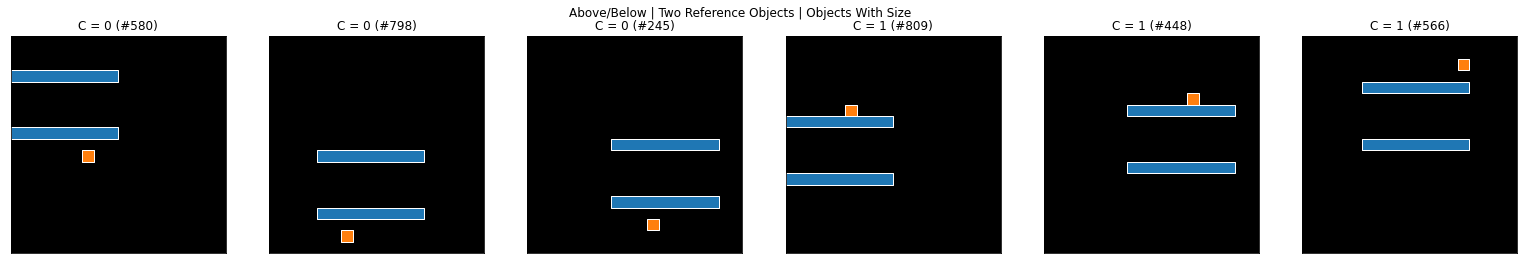

### train_reference_test_target

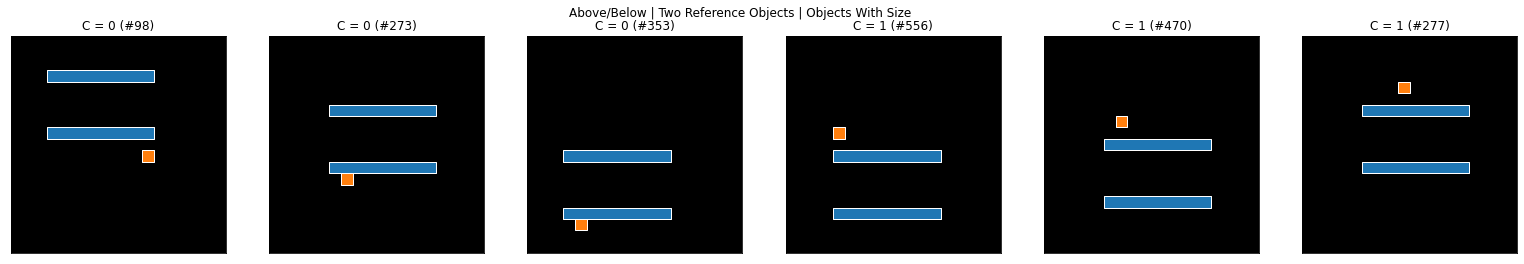

### test_reference_train_target

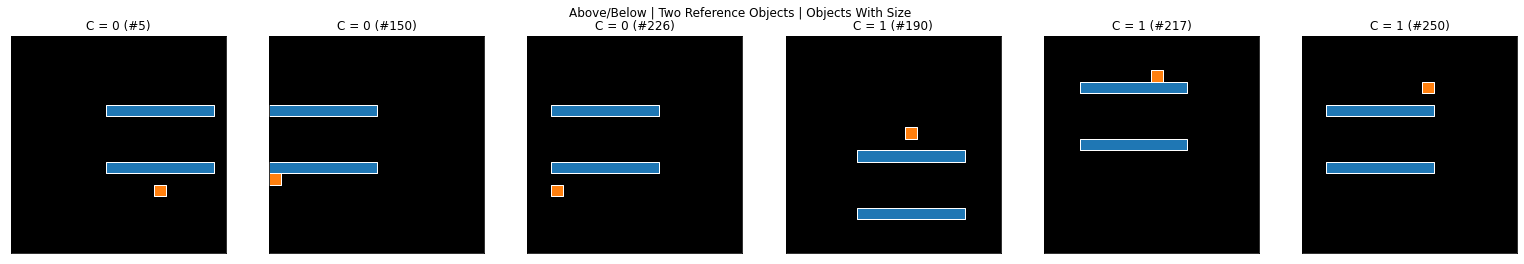

### test_reference_test_target

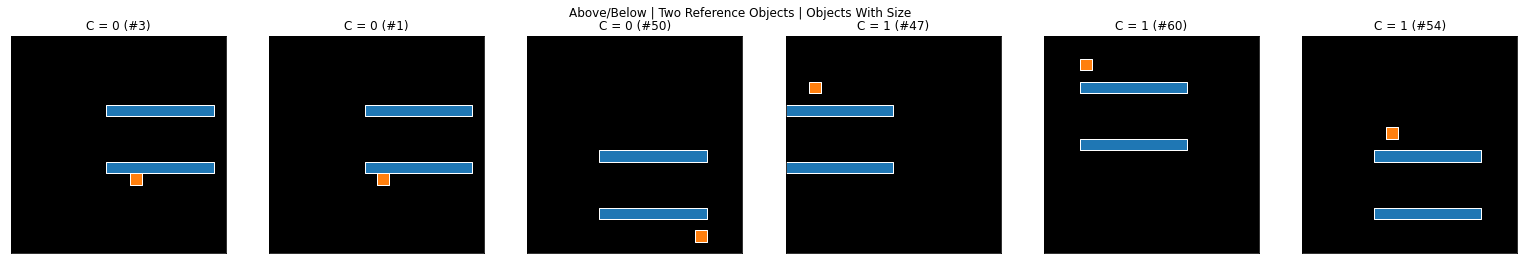

-----

-----

## Between | two reference objects | objects without size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1819 | 1: 1809

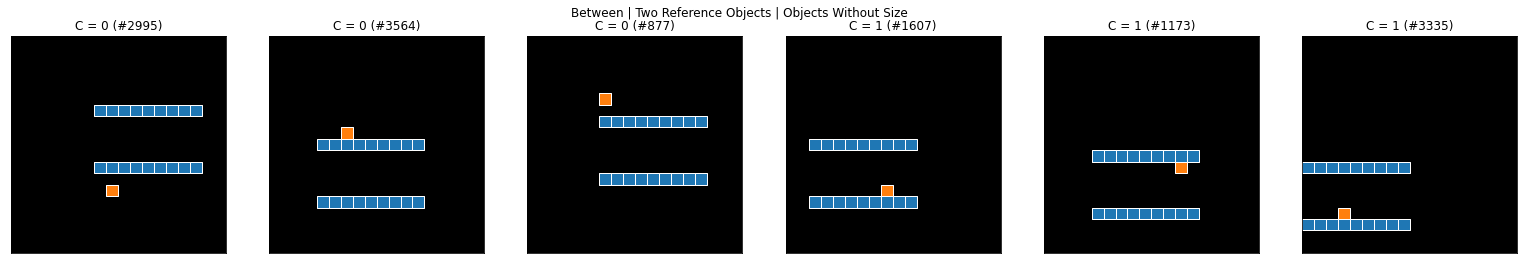

### train_reference_test_target

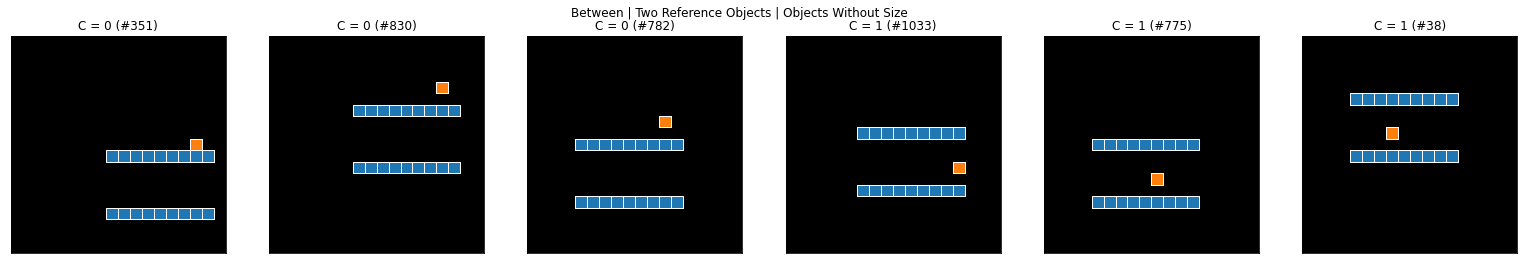

### test_reference_train_target

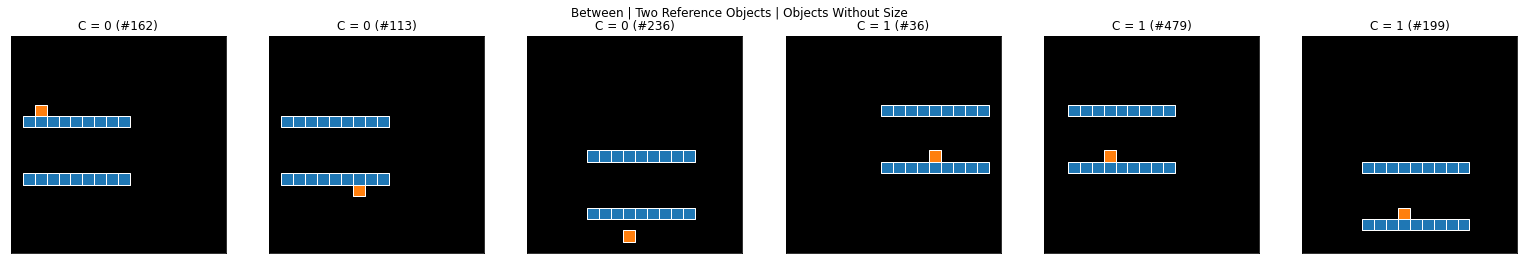

### test_reference_test_target

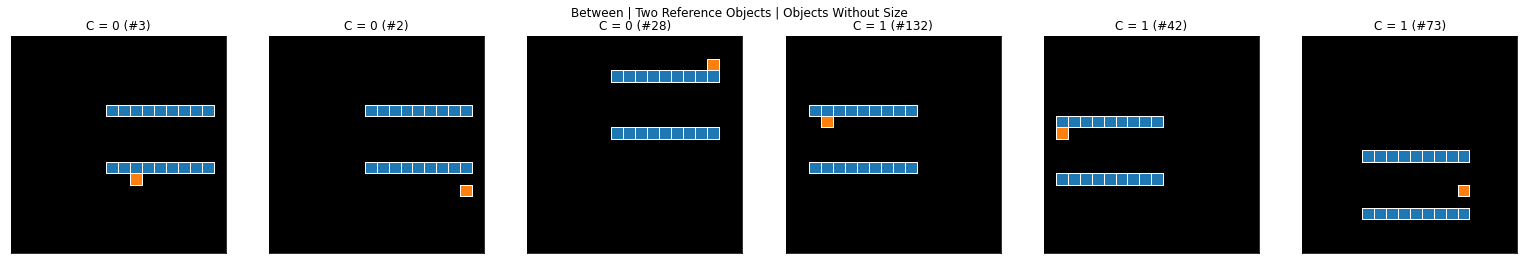

-----

-----

## Between | two reference objects | objects with size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1819 | 1: 1809

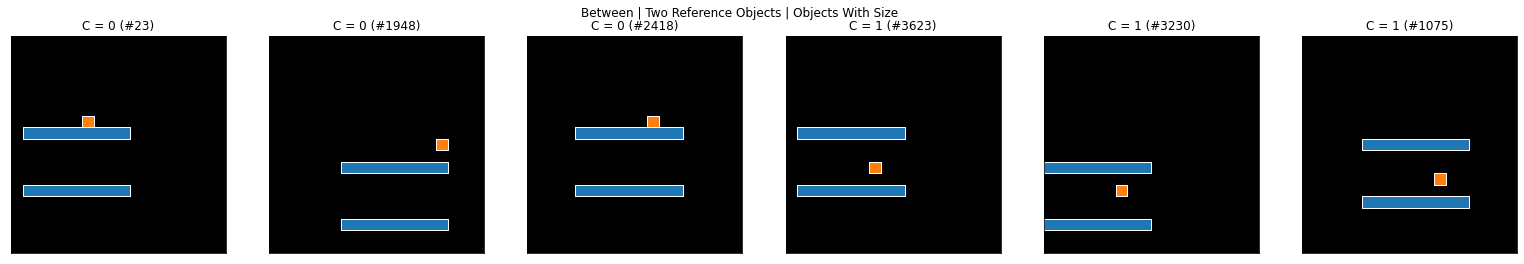

### train_reference_test_target

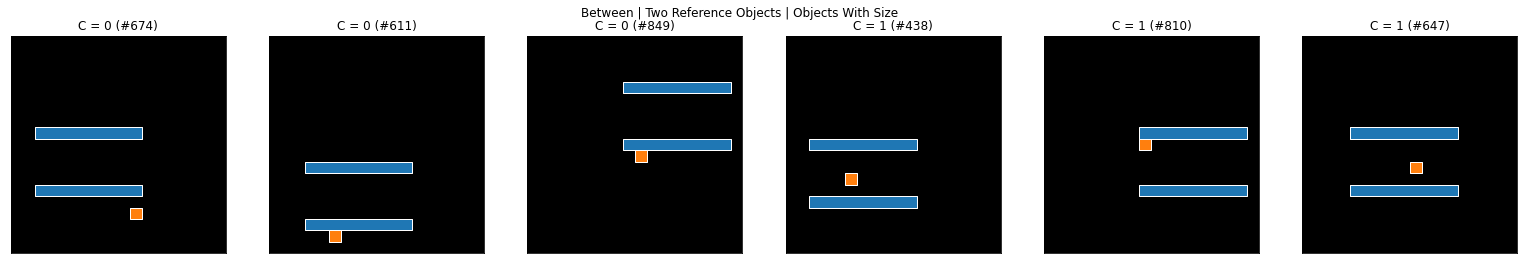

### test_reference_train_target

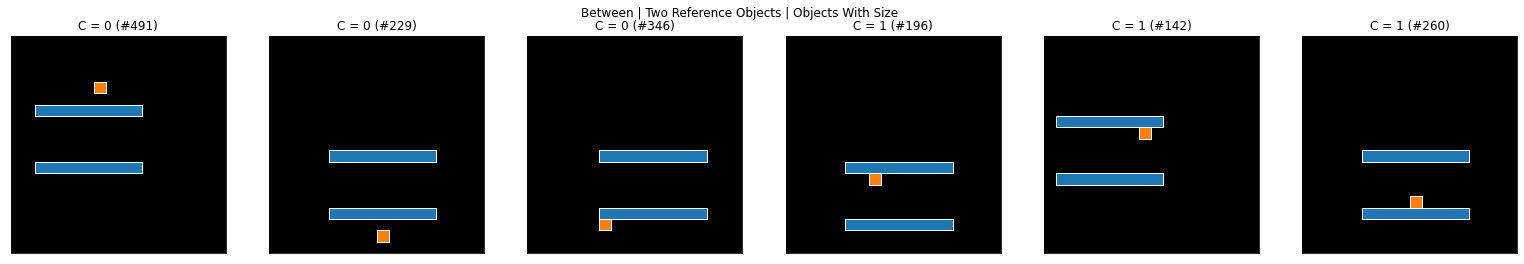

### test_reference_test_target

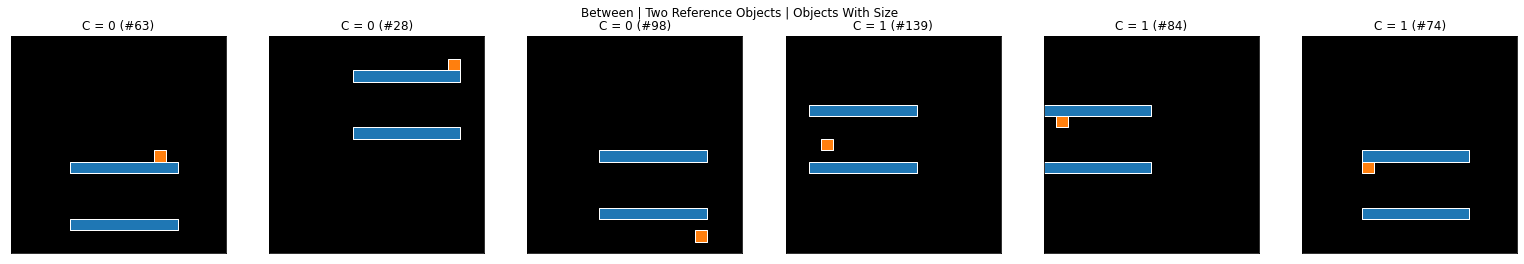

-----

-----

In [9]:
REFERENCE_OBJECT_SIZE = 9
TARGET_OBJECT_SIZE = 1
X_MAX = 18
Y_MAX = 18
SEED = 33
EXAMPLES_PER_CLASS = 3
PROP_TRAIN_REF_LOCATIONS = 0.90
PROP_TRAIN_TARGET_LOCATIONS = 0.8
SUBSAMPLE = None

indices = {}

ONE_OR_TWO_DATASETS = defaultdict(dict)
    

for between_relation in (False, True):
    for two_reference_objects in (False, True):
        if between_relation and not two_reference_objects:
            continue

        for generator_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize):
            title = f'{"Between" if between_relation else "Above/below"} | {"two reference objects" if two_reference_objects else "one reference object"} | {NAMES[generator_class]}'
            display(Markdown(f'## {title}'))
            gen = generator_class(SEED, REFERENCE_OBJECT_SIZE, False, TARGET_OBJECT_SIZE)
            dataset = CombinedQuinnDatasetGenerator(gen, X_MAX, Y_MAX + int(two_reference_objects), SEED, 
                two_reference_objects=two_reference_objects,
                between_relation=between_relation,
                prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS,
                # add_neither_train=ADD_NEITHER, add_neither_test=ADD_NEITHER,
                subsample_train_size=SUBSAMPLE)
            
            ONE_OR_TWO_DATASETS[between_relation, two_reference_objects][generator_class] = dataset
            
            train = dataset.get_training_dataset()
            label_arr = np.array(train.labels)
            unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
        #     print(len(train), unique_labels, unique_counts)
            
            test_datasets = dataset.get_test_datasets()
        #     print([(key, len(test_datasets[key])) for key in test_datasets])

            display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

            total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
            display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))
            
            class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
            display(Markdown(f'Class balance in the training set: {class_sizes}'))
            train_indices = {}
            faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

            plot_single_dataset(train, train_indices, faux_generators=faux_generators)
            
            for test_set_name, test_set in test_datasets.items():
                display(Markdown(f'### {test_set_name}'))
                test_indices = {}
                plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)
            
            train_indices = {}
            
            display(Markdown('-----'))
            display(Markdown('-----'))

## Above/below | two reference objects | objects without size | Adjacent

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1825 | 1: 1803

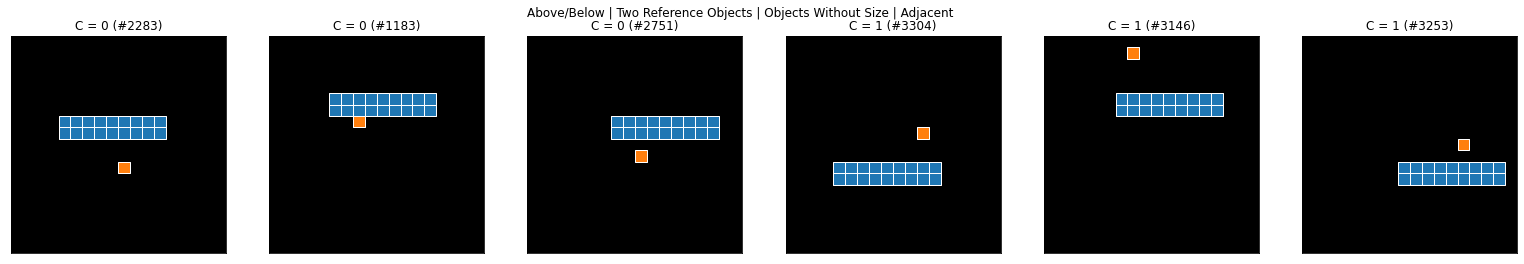

### train_reference_test_target

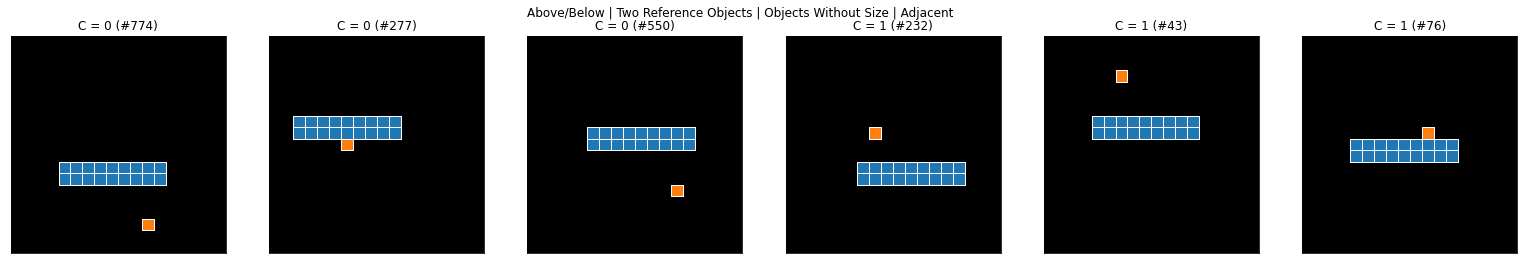

### test_reference_train_target

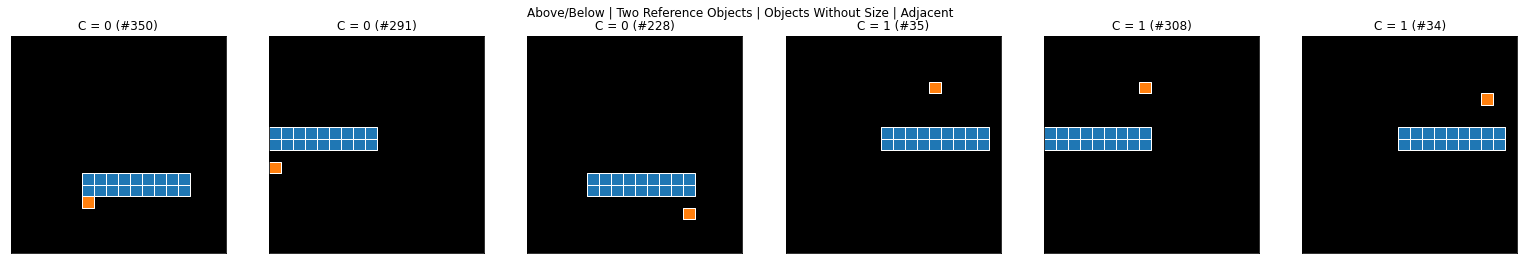

### test_reference_test_target

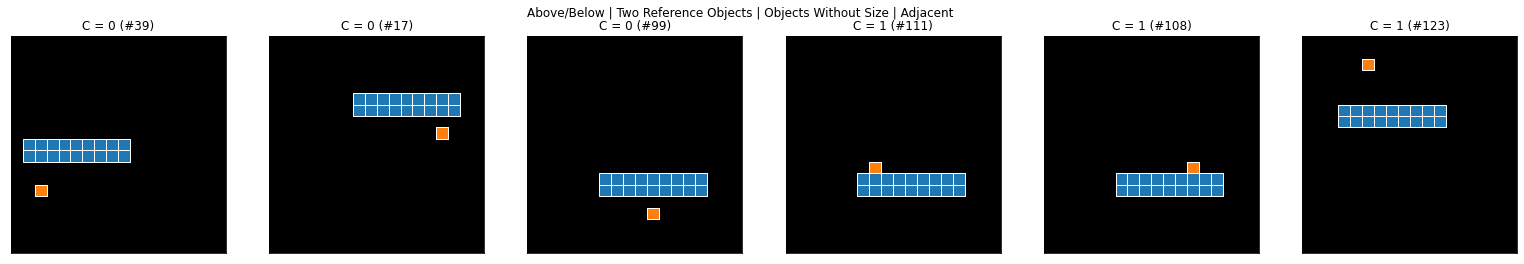

-----

-----

In [10]:
between_relation = False
two_reference_objects = True
generator_class = ObjectGeneratorWithoutSize

title = f'{"Between" if between_relation else "Above/below"} | {"two reference objects" if two_reference_objects else "one reference object"} | {NAMES[generator_class]} | Adjacent'
display(Markdown(f'## {title}'))
gen = generator_class(SEED, REFERENCE_OBJECT_SIZE, False, TARGET_OBJECT_SIZE)
dataset = CombinedQuinnDatasetGenerator(gen, X_MAX, Y_MAX + int(two_reference_objects), SEED, 
    two_reference_objects=two_reference_objects,
    between_relation=between_relation,
    adjacent_reference_objects=True,
    prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
    prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS,
    # add_neither_train=ADD_NEITHER, add_neither_test=ADD_NEITHER,
    subsample_train_size=SUBSAMPLE)


train = dataset.get_training_dataset()
label_arr = np.array(train.labels)
unique_labels, unique_counts = np.unique(label_arr, return_counts=True)

test_datasets = dataset.get_test_datasets()

display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))

class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
display(Markdown(f'Class balance in the training set: {class_sizes}'))
train_indices = {}
faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

plot_single_dataset(train, train_indices, faux_generators=faux_generators)

for test_set_name, test_set in test_datasets.items():
    display(Markdown(f'### {test_set_name}'))
    test_indices = {}
    plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)

train_indices = {}

display(Markdown('-----'))
display(Markdown('-----'))

## Above/below | two reference objects | objects without size | Adjacent

Of the reference object locations, train: 81, test: 9 

Training set size: 4082 | Validation set size: 454 | Test set size: 1944

Class balance in the training set: 0: 2037 | 1: 2045

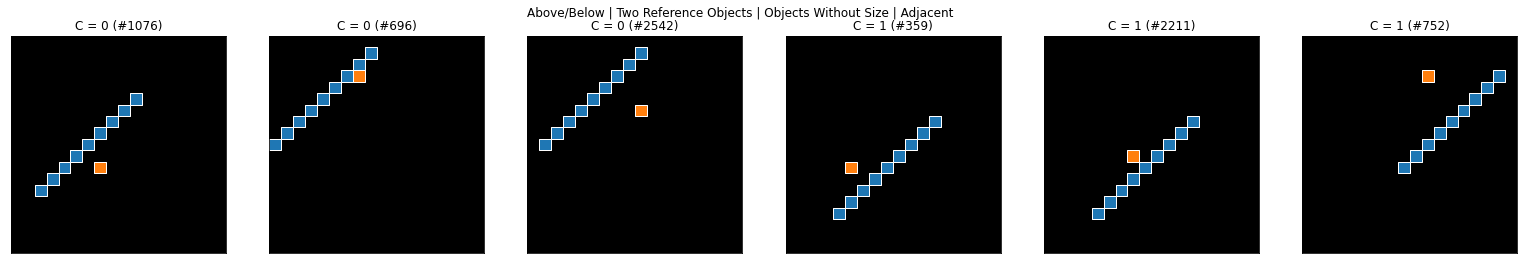

### train_reference_test_target

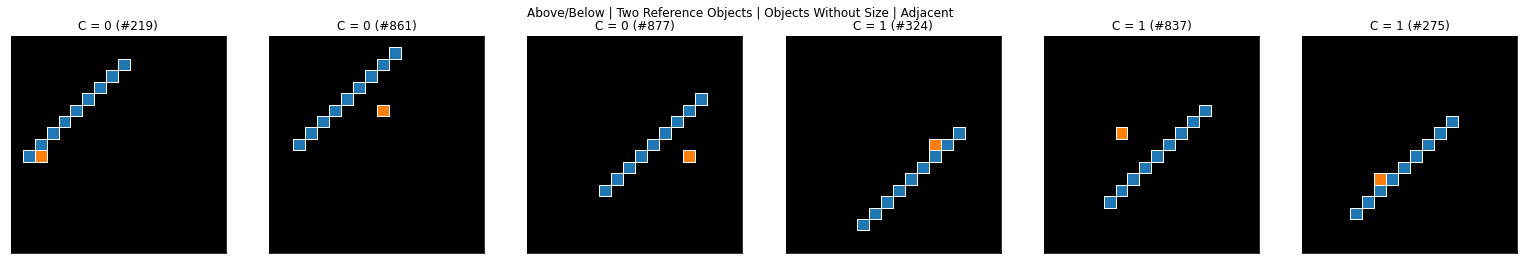

### test_reference_train_target

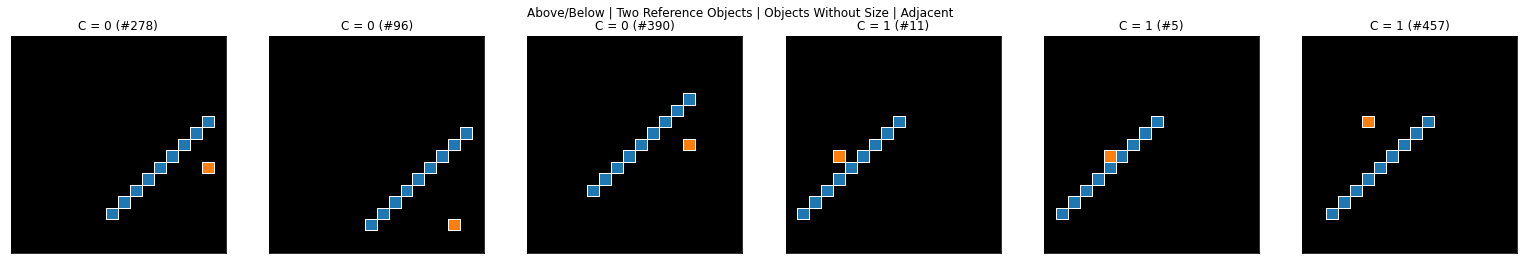

### test_reference_test_target

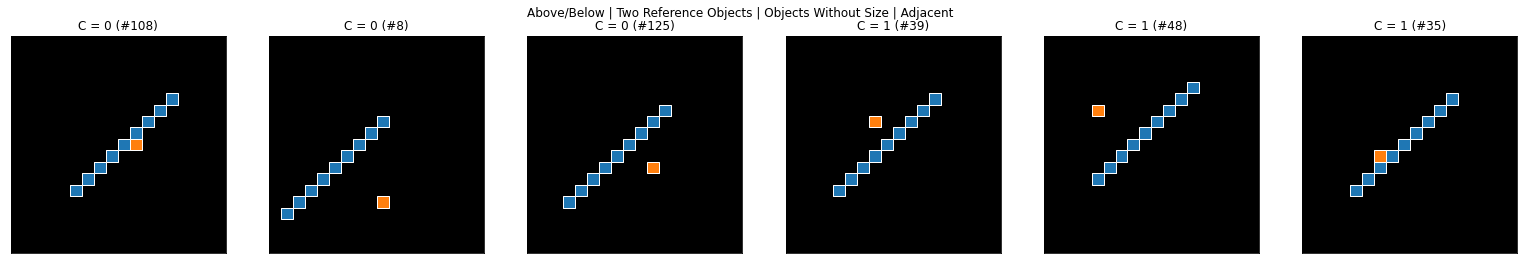

-----

-----

In [11]:
between_relation = False
two_reference_objects = True
generator_class = ObjectGeneratorWithoutSize

title = f'{"Between" if between_relation else "Above/below"} | {"two reference objects" if two_reference_objects else "one reference object"} | {NAMES[generator_class]} | Adjacent'
display(Markdown(f'## {title}'))
gen = ObjectGeneratorWithoutSize(SEED, REFERENCE_OBJECT_SIZE, True, TARGET_OBJECT_SIZE)
dataset = DiagonalAboveBelowDatasetGenerator(gen, X_MAX, Y_MAX + int(two_reference_objects), SEED, 
    prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
    prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS,
    subsample_train_size=SUBSAMPLE)


train = dataset.get_training_dataset()
label_arr = np.array(train.labels)
unique_labels, unique_counts = np.unique(label_arr, return_counts=True)

test_datasets = dataset.get_test_datasets()

display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))

class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
display(Markdown(f'Class balance in the training set: {class_sizes}'))
train_indices = {}
faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

plot_single_dataset(train, train_indices, faux_generators=faux_generators)

for test_set_name, test_set in test_datasets.items():
    display(Markdown(f'### {test_set_name}'))
    test_indices = {}
    plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)

train_indices = {}

display(Markdown('-----'))

display(Markdown('-----'))

## Diagonal with Start and End

Of the reference object locations, train: 81, test: 9 

Training set size: 4082 | Validation set size: 454 | Test set size: 1944

Class balance in the training set: 0: 2037 | 1: 2045

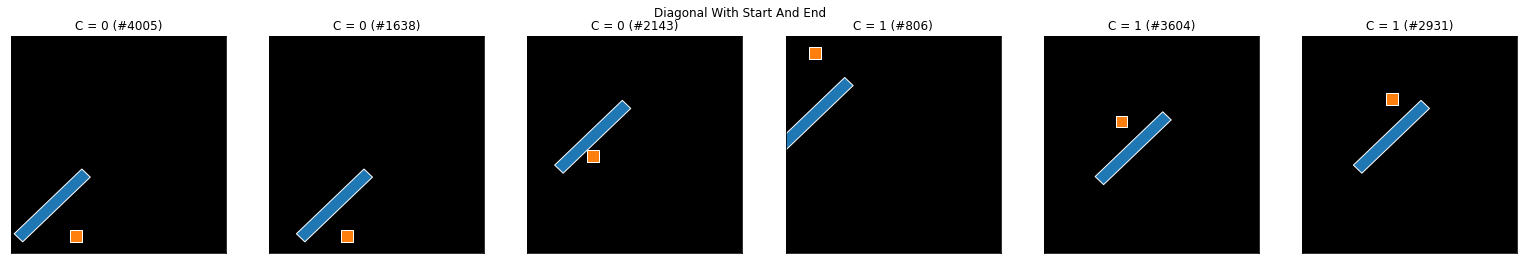

### train_reference_test_target

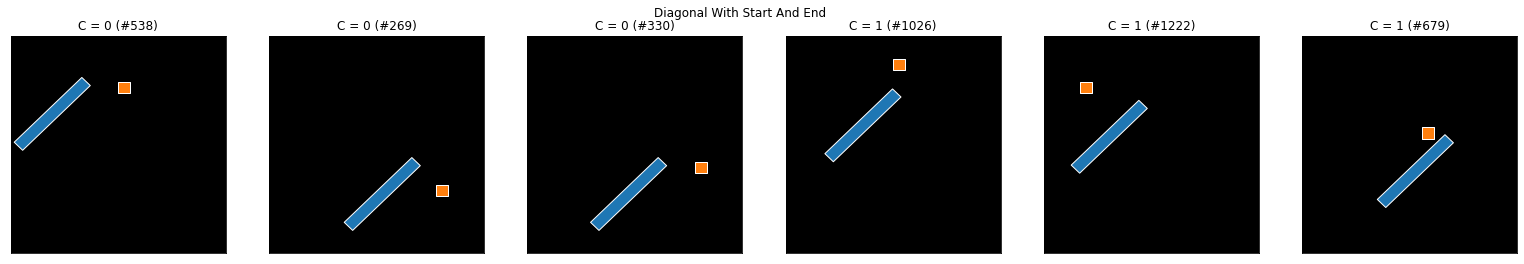

### test_reference_train_target

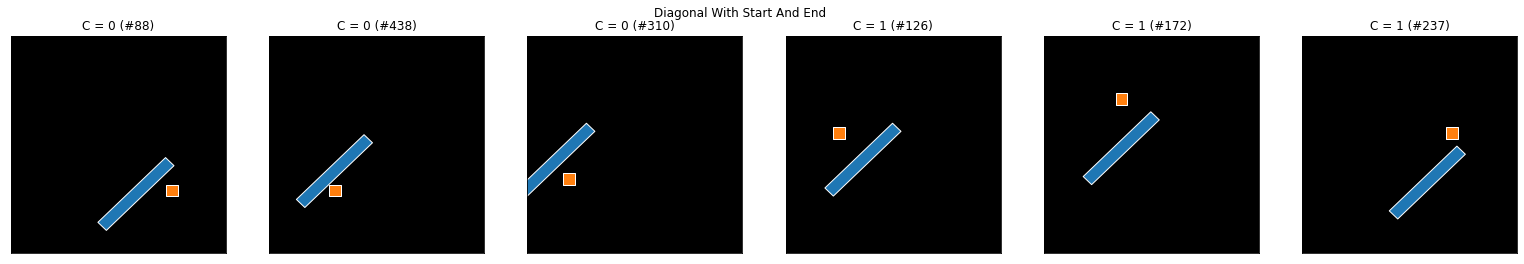

### test_reference_test_target

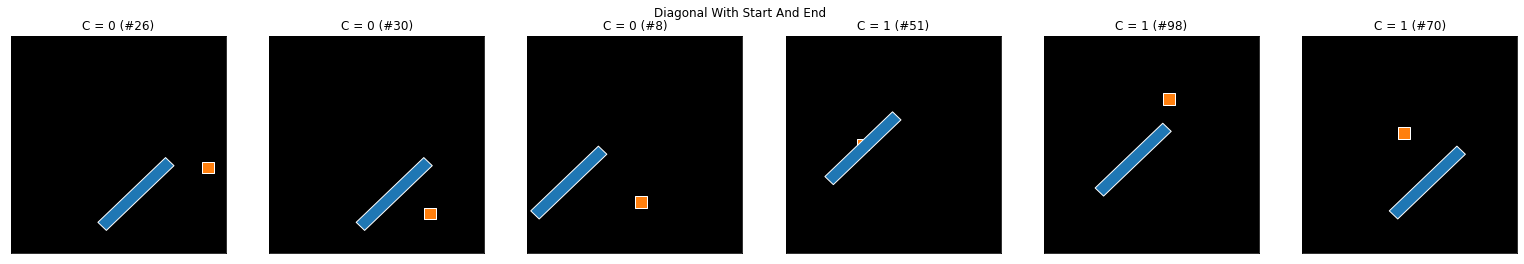

-----

-----

In [12]:
between_relation = False
two_reference_objects = True
generator_class = StartEndObjectGenerator

title = f'Diagonal with Start and End'
display(Markdown(f'## {title}'))
gen = StartEndObjectGenerator(SEED, REFERENCE_OBJECT_SIZE, True, TARGET_OBJECT_SIZE)
dataset = DiagonalAboveBelowDatasetGenerator(gen, X_MAX, Y_MAX + int(two_reference_objects), SEED, 
    prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
    prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS,
    subsample_train_size=SUBSAMPLE)


train = dataset.get_training_dataset()
label_arr = np.array(train.labels)
unique_labels, unique_counts = np.unique(label_arr, return_counts=True)

test_datasets = dataset.get_test_datasets()

display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))

class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
display(Markdown(f'Class balance in the training set: {class_sizes}'))
train_indices = {}
faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

plot_single_dataset(train, train_indices, faux_generators=faux_generators)

for test_set_name, test_set in test_datasets.items():
    display(Markdown(f'### {test_set_name}'))
    test_indices = {}
    plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)

train_indices = {}

display(Markdown('-----'))

display(Markdown('-----'))

## Between with Start and End

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1819 | 1: 1809

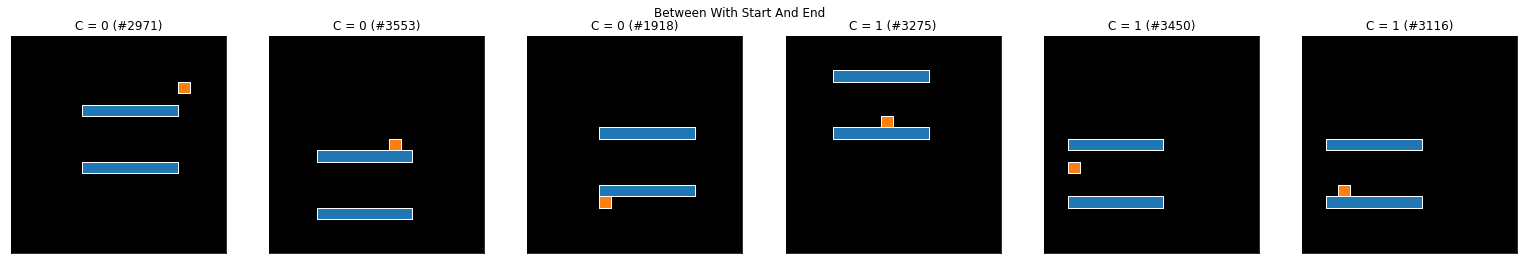

### train_reference_test_target

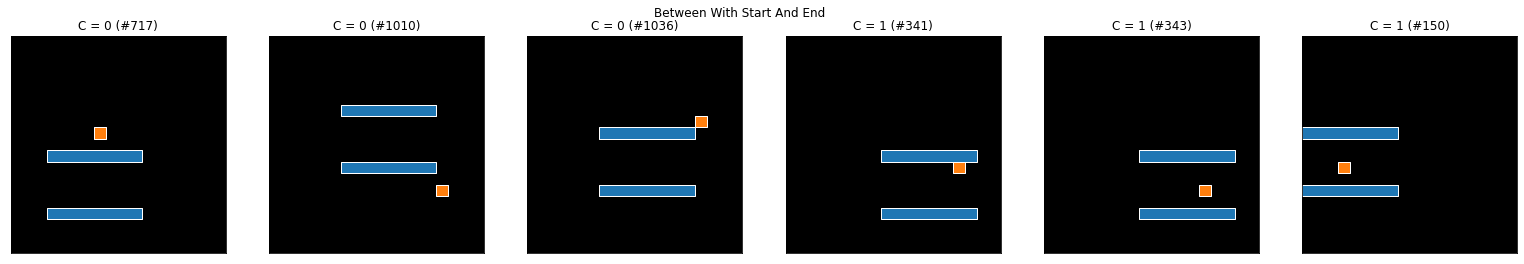

### test_reference_train_target

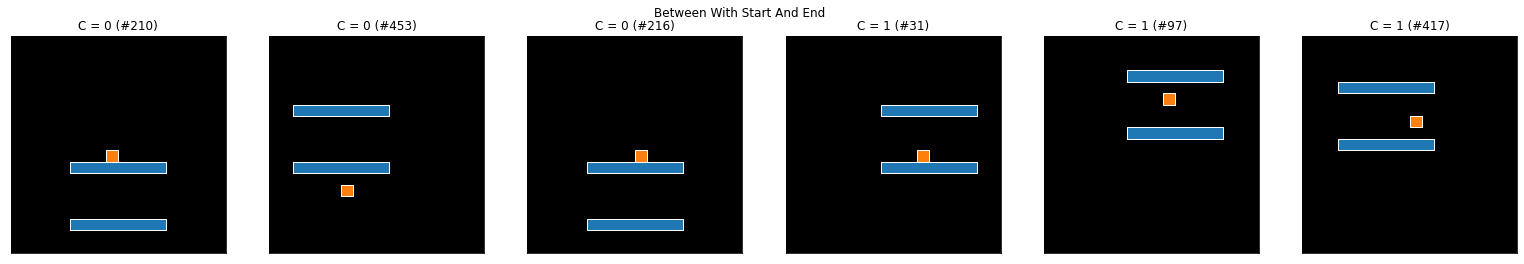

### test_reference_test_target

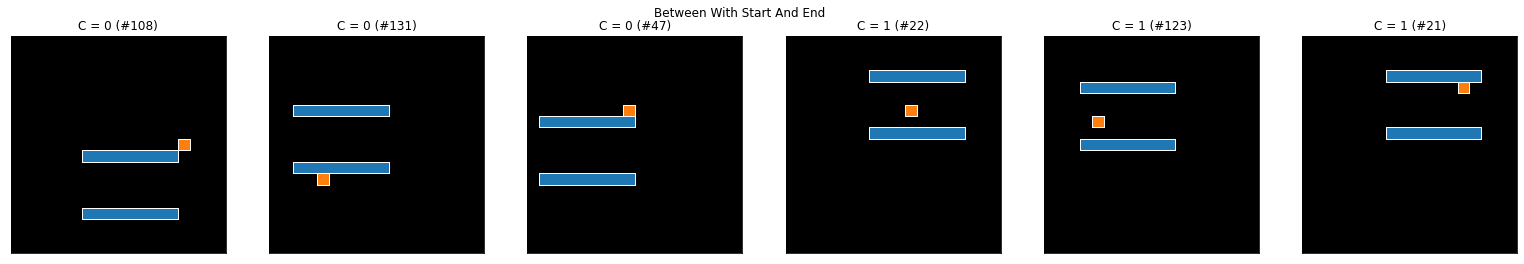

-----

-----

In [16]:
between_relation = True
two_reference_objects = True
generator_class = StartEndObjectGenerator

title = f'Between with Start and End'
display(Markdown(f'## {title}'))
gen = StartEndObjectGenerator(SEED, REFERENCE_OBJECT_SIZE, False, TARGET_OBJECT_SIZE)
dataset = CombinedQuinnDatasetGenerator(gen, X_MAX, Y_MAX + int(two_reference_objects), SEED, 
    two_reference_objects=two_reference_objects,
    between_relation=between_relation,
    prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
    prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS,
    subsample_train_size=SUBSAMPLE)


train = dataset.get_training_dataset()
label_arr = np.array(train.labels)
unique_labels, unique_counts = np.unique(label_arr, return_counts=True)

test_datasets = dataset.get_test_datasets()

display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))

class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
display(Markdown(f'Class balance in the training set: {class_sizes}'))
train_indices = {}
faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

plot_single_dataset(train, train_indices, faux_generators=faux_generators)

for test_set_name, test_set in test_datasets.items():
    display(Markdown(f'### {test_set_name}'))
    test_indices = {}
    plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)

train_indices = {}

display(Markdown('-----'))

display(Markdown('-----'))

## Left / Right

Training set size: 261 | Validation set size: 29 | Test set size: 34

Class balance in the training set: 0: 131 | 1: 130

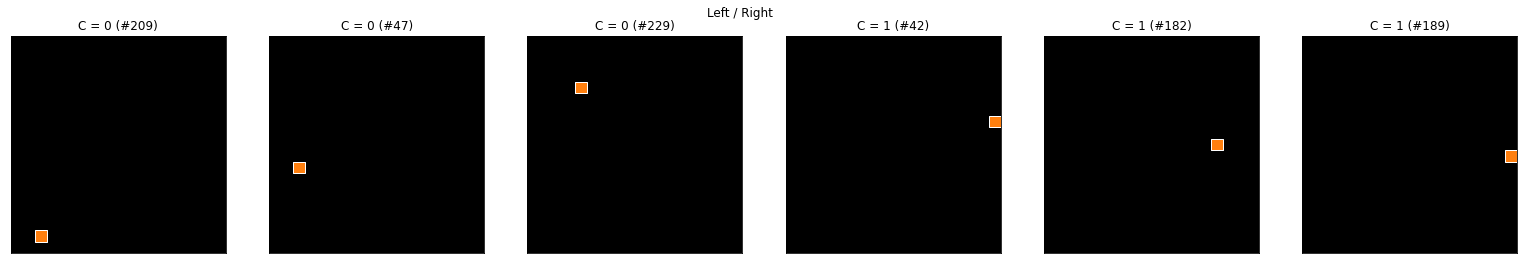

### test

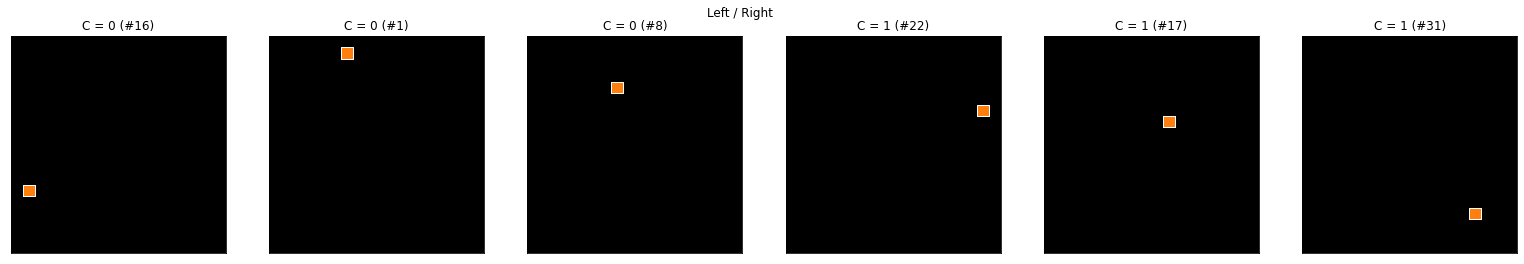

-----

-----

In [ ]:
between_relation = False
two_reference_objects = False
generator_class = ObjectGeneratorWithoutSize

title = f'Left / Right'
display(Markdown(f'## {title}'))
gen = ObjectGeneratorWithoutSize(SEED, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
dataset = QuinnNoReferenceDatasetGenerator(gen, X_MAX, Y_MAX, SEED, subsample_train_size=SUBSAMPLE)


train = dataset.get_training_dataset()
label_arr = np.array(train.labels)
unique_labels, unique_counts = np.unique(label_arr, return_counts=True)

test_datasets = dataset.get_test_datasets()

# display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))

class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
display(Markdown(f'Class balance in the training set: {class_sizes}'))
train_indices = {}
faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

plot_single_dataset(train, train_indices, faux_generators=faux_generators)

for test_set_name, test_set in test_datasets.items():
    display(Markdown(f'### {test_set_name}'))
    test_indices = {}
    plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)

train_indices = {}

display(Markdown('-----'))
display(Markdown('-----'))

## Top / Bottom

Training set size: 261 | Validation set size: 29 | Test set size: 34

Class balance in the training set: 0: 131 | 1: 130

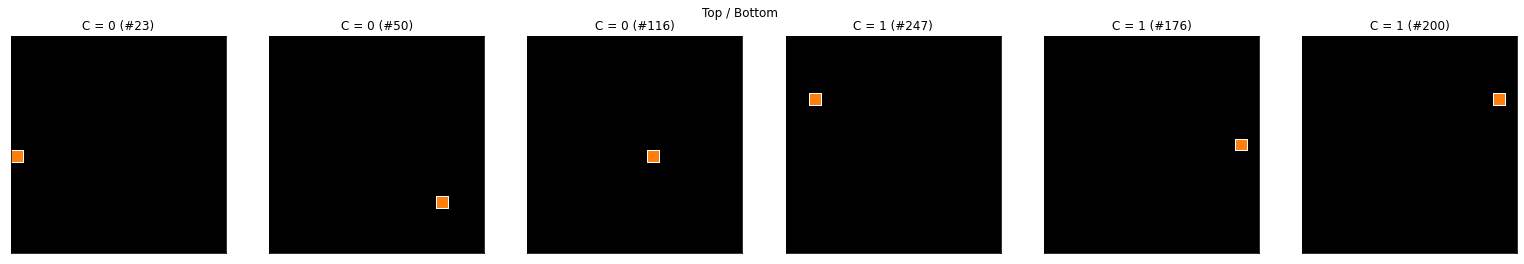

### test

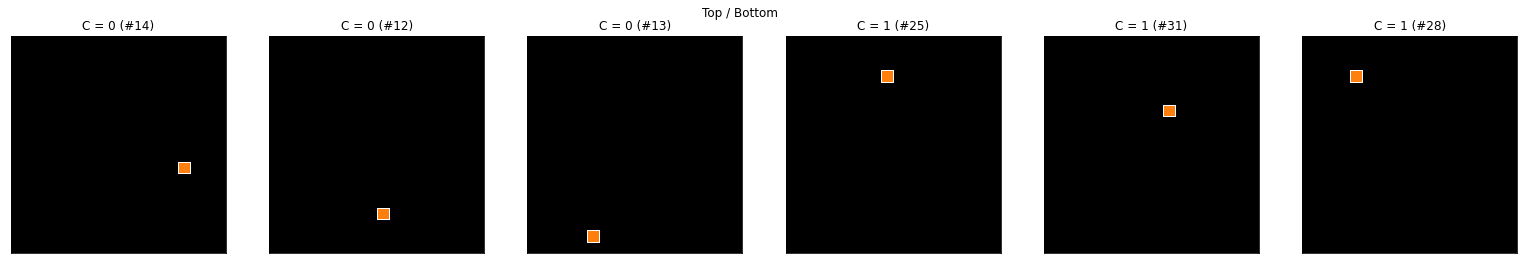

-----

-----

In [ ]:
between_relation = False
two_reference_objects = False
generator_class = ObjectGeneratorWithoutSize

title = f'Top / Bottom'
display(Markdown(f'## {title}'))
gen = ObjectGeneratorWithoutSize(SEED, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
dataset = QuinnNoReferenceDatasetGenerator(gen, X_MAX, Y_MAX, SEED, left_right=False, subsample_train_size=SUBSAMPLE)


train = dataset.get_training_dataset()
label_arr = np.array(train.labels)
unique_labels, unique_counts = np.unique(label_arr, return_counts=True)

test_datasets = dataset.get_test_datasets()

# display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))

class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
display(Markdown(f'Class balance in the training set: {class_sizes}'))
train_indices = {}
faux_generators = ONE_OR_TWO_QUINN_FAUX_GENERATORS[(between_relation, two_reference_objects)]

plot_single_dataset(train, train_indices, faux_generators=faux_generators)

for test_set_name, test_set in test_datasets.items():
    display(Markdown(f'### {test_set_name}'))
    test_indices = {}
    plot_single_dataset(test_set, test_indices, faux_generators=faux_generators)

train_indices = {}

display(Markdown('-----'))
display(Markdown('-----'))

In [ ]:
raise ValueError('Done')

ValueError: Done

In [ ]:
def create_grid(start_x, end_x, start_y, end_y, obj_type=0):
    if end_x == start_x:
        end_x = start_x + 1
    
    if end_y == start_y:
        end_y = start_y + 1
        
    locations = torch.tensor([t for t in itertools.product(range(start_x, end_x), range(start_y, end_y))],
                             dtype=torch.float)
    type_tensor = torch.zeros(1, 2, dtype=torch.float)
    type_tensor[0, obj_type] = 1.0
    return torch.cat((locations, type_tensor.repeat(locations.shape[0], 1)), dim=1)


def add_patches_to_ax(ax, patches, colors, alpha=0.75, linestyle='-',
                         bg_color='black', cmap=plt.cm.tab10, clim=(0, 10)):
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    collection.set_alpha(alpha)
    collection.set_linestyle(linestyle)
    if bg_color == 'black':
        collection.set_edgecolor('white')
    else:
        collection.set_edgecolor('black')
    collection.set_clim(*clim)
    ax.add_collection(collection)
    

In [ ]:
length = 9
above_below_start = 5
above_below_height = 7
between_start = 3
between_lower_height = 9
between_higher_height = 14

fig = plt.figure(figsize=(9, 4), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.125)

bg_color = 'white'
title_font_size = 36

above_below_ax = plt.subplot(1, 2, 1)
above_below_ax.set_title('Above/Below', fontsize=title_font_size, fontweight='bold')

refernece = create_grid(above_below_start, above_below_start + length, above_below_height, above_below_height + 1)
visualize_objects(refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  above_below_ax, bg_color=bg_color)

above_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height + 1, above_below_height + 5, 1)
above_patches, above_colors = create_patches_and_colors(above_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, above_patches, above_colors, 
                  bg_color=bg_color, linestyle=':')

below_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height - 4, above_below_height, 1)
below_patches, below_colors = create_patches_and_colors(below_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, below_patches, below_colors, 
                  bg_color=bg_color, linestyle=':')


between_ax = plt.subplot(1, 2, 2)
between_ax.set_title('Between', fontsize=title_font_size, fontweight='bold')

higher_refernece = create_grid(between_start, between_start + length, between_higher_height, between_higher_height + 1)
visualize_objects(higher_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

lower_refernece = create_grid(between_start, between_start + length, between_lower_height, between_lower_height + 1)
visualize_objects(lower_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

between_above_target_grid = create_grid(between_start, between_start + length, between_higher_height + 1, between_higher_height + 3, 1)
between_above_patches, between_above_colors = create_patches_and_colors(
    between_above_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_above_patches, between_above_colors, 
                  bg_color=bg_color, linestyle=':')

between_target_grid = create_grid(between_start, between_start + length, between_lower_height + 1, between_higher_height, 1)
between_patches, between_colors = create_patches_and_colors(
    between_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_patches, between_colors, 
                  bg_color=bg_color, linestyle=':')

between_below_target_grid = create_grid(between_start, between_start + length, between_lower_height - 2, between_lower_height, 1)
between_below_patches, between_below_colors = create_patches_and_colors(
    between_below_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_below_patches, between_below_colors, 
                  bg_color=bg_color, linestyle=':')

save_plot(f'exp1_target_grid_stimuli_{bg_color}_background.pdf')

plt.show()

In [ ]:
one_obj_dataset = ONE_OR_TWO_DATASETS[ObjectGeneratorWithoutSize, False]
two_obj_dataset = ONE_OR_TWO_DATASETS[ObjectGeneratorWithoutSize, True]

In [ ]:
above_below_c_0_idx = 100
above_below_c_1_idx = 2700
between_c_0_idx = 29
between_c_1_idx = 0

fig = plt.figure(figsize=(17, 4), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.125)

bg_color = 'white'
title_font_size = 36

above_below_c0_ax = plt.subplot(1, 4, 1)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c0_ax, bg_color=bg_color)
above_below_c0_ax.set_title('Above', fontsize=title_font_size, fontweight='bold')

above_below_c1_ax = plt.subplot(1, 4, 2)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c1_ax, bg_color=bg_color)
above_below_c1_ax.set_title('Below', fontsize=title_font_size, fontweight='bold')


between_c0_ax = plt.subplot(1, 4, 3)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c0_ax, bg_color=bg_color)
between_c0_ax.set_title('Between', fontsize=title_font_size, fontweight='bold')

between_c1_ax = plt.subplot(1, 4, 4)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c1_ax, bg_color=bg_color)
between_c1_ax.set_title('Outside', fontsize=title_font_size, fontweight='bold')


save_plot(f'exp1_example_stimuli_{bg_color}_background.pdf')

plt.show()

In [ ]:
length = 9
above_below_start = 5
above_below_height = 7
between_start = 3
between_lower_height = 9
between_higher_height = 14

fig = plt.figure(figsize=(27, 4), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.125)

title_font_size = 40
bg_color = 'white'

above_below_ax = plt.subplot(1, 6, 1)
above_below_ax.set_title('Above/\nBelow', fontsize=title_font_size, fontweight='bold')

refernece = create_grid(above_below_start, above_below_start + length, above_below_height, above_below_height + 1)
visualize_objects(refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  above_below_ax, bg_color=bg_color)

above_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height + 1, above_below_height + 5, 1)
above_patches, above_colors = create_patches_and_colors(above_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, above_patches, above_colors, 
                  bg_color=bg_color, linestyle=':')

below_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height - 4, above_below_height, 1)
below_patches, below_colors = create_patches_and_colors(below_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, below_patches, below_colors, 
                  bg_color=bg_color, linestyle=':')


between_ax = plt.subplot(1, 6, 2)
between_ax.set_title('Between/\nOutside', fontsize=title_font_size, fontweight='bold')

higher_refernece = create_grid(between_start, between_start + length, between_higher_height, between_higher_height + 1)
visualize_objects(higher_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

lower_refernece = create_grid(between_start, between_start + length, between_lower_height, between_lower_height + 1)
visualize_objects(lower_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

between_above_target_grid = create_grid(between_start, between_start + length, between_higher_height + 1, between_higher_height + 3, 1)
between_above_patches, between_above_colors = create_patches_and_colors(
    between_above_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_above_patches, between_above_colors, 
                  bg_color=bg_color, linestyle=':')

between_target_grid = create_grid(between_start, between_start + length, between_lower_height + 1, between_higher_height, 1)
between_patches, between_colors = create_patches_and_colors(
    between_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_patches, between_colors, 
                  bg_color=bg_color, linestyle=':')

between_below_target_grid = create_grid(between_start, between_start + length, between_lower_height - 2, between_lower_height, 1)
between_below_patches, between_below_colors = create_patches_and_colors(
    between_below_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_below_patches, between_below_colors, 
                  bg_color=bg_color, linestyle=':')

above_below_c0_ax = plt.subplot(1, 6, 3)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c0_ax, bg_color=bg_color)
above_below_c0_ax.set_title('Above', fontsize=title_font_size, fontweight='bold')

above_below_c1_ax = plt.subplot(1, 6, 4)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c1_ax, bg_color=bg_color)
above_below_c1_ax.set_title('Below', fontsize=title_font_size, fontweight='bold')


between_c0_ax = plt.subplot(1, 6, 5)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c0_ax, bg_color=bg_color)
between_c0_ax.set_title('Between', fontsize=title_font_size, fontweight='bold')

between_c1_ax = plt.subplot(1, 6, 6)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c1_ax, bg_color=bg_color)
between_c1_ax.set_title('Outside', fontsize=title_font_size, fontweight='bold')


save_plot(f'exp1_stimuli_combined.pdf')

plt.show()

In [ ]:
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  bg_color=bg_color)

In [ ]:
one_obj_dataset.get_training_dataset()[above_below_c_1_idx][0]

In [ ]:
one_obj_dataset.train_dataset.objects[2500]

In [ ]:
ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize].field_generators['x'].max_coord

In [ ]:
len(one_obj_dataset.train_reference_object_locations), len(two_obj_dataset.train_reference_object_locations)

In [ ]:
len(one_obj_dataset.test_reference_object_locations), len(two_obj_dataset.test_reference_object_locations)

In [ ]:
len(one_obj_dataset.train_target_locations), len(two_obj_dataset.train_target_locations)

In [ ]:
len(one_obj_dataset.test_target_locations), len(two_obj_dataset.test_target_locations)

In [ ]:
one_obj_dataset._generate_and_split_target_object_locations()

In [ ]:
(695 + 2802) // 2

In [ ]:
dataset.single_reference_height, dataset.bottom_reference_height, dataset.top_reference_height